In [ ]:
import numpy as np
from numpy.linalg import inv, slogdet


class MaxEntLQR:

    def __init__(self, A, B, Q, R, W, gamma=0.95, alpha=1.0,
                            max_iter=5000, tol=1e-10, verbose=False):
        """
        Solve KL-regularized LQR with observable additive noise:
            x_{t+1} = A x_t + B u_t + a_t,   a_t ~ N(0,W * W^T), observed before u_t.
        Value: V(x,a) = [x; a]^T P [x; a] + v, with P partitioned.
        Returns P_blocks, v, Kx, Ka, Sigma.
        """
        n = A.shape[0]
        m = B.shape[1]

        # initialize
        P_xx = Q.copy()
        v = 0.0

        for it in range(max_iter):
            S = R + gamma * B.T @ P_xx @ B  # m x m, positive definite
            S_inv = inv(S)

            # Riccati-like update for P_xx
            P_xx_new = Q + gamma * A.T @ P_xx @ A \
                      - (gamma**2) * A.T @ P_xx @ B @ S_inv @ B.T @ P_xx @ A

            # compute other blocks from P_xx_new (we use updated P_xx for consistency)
            P_xx_tmp = P_xx_new
            S_tmp = R + gamma * B.T @ P_xx_tmp @ B
            S_tmp_inv = inv(S_tmp)

            P_xa = gamma * A.T @ P_xx_tmp - (gamma**2) * A.T @ P_xx_tmp @ B @ S_tmp_inv @ B.T @ P_xx_tmp
            P_aa = gamma * P_xx_tmp - (gamma**2) * P_xx_tmp @ B @ S_tmp_inv @ B.T @ P_xx_tmp

            # constant term update
            # v_new: (1 - gamma) v = -alpha m/2 ln(pi alpha) + alpha/2 ln det S + gamma tr(P_aa W)
            sign, logdetS = slogdet(S_tmp)  # stable log-det
            if sign <= 0:
                raise RuntimeError("S_tmp not positive definite in iteration.")
            v_new = ( - alpha * (m/2.0) * np.log(np.pi * alpha)
                      + 0.5 * alpha * logdetS
                      + gamma * np.trace(P_aa @ W) ) / (1.0 - gamma)

            # check convergence (on P_xx and v)
            if np.linalg.norm(P_xx_new - P_xx, ord='fro') < tol and abs(v_new - v) < tol:
                P_xx = P_xx_new
                v = v_new
                break

            P_xx = P_xx_new
            v = v_new
        else:
            if verbose:
                print("Warning: max_iter reached without convergence.")

        # final S and inverses
        S = R + gamma * B.T @ P_xx @ B
        S_inv = inv(S)

        # compute final block matrices
        P_xa = gamma * A.T @ P_xx - (gamma**2) * A.T @ P_xx @ B @ S_inv @ B.T @ P_xx
        P_aa = gamma * P_xx - (gamma**2) * P_xx @ B @ S_inv @ B.T @ P_xx

        # policy gains and covariance
        Kx = gamma * S_inv @ B.T @ P_xx @ A
        Ka = gamma * S_inv @ B.T @ P_xx
        Sigma = (alpha / 2.0) * S_inv

        # package P as block matrix for user
        P = np.block([[P_xx, P_xa],
                      [P_xa.T, P_aa]])

        self.A = A
        self.B = B
        self.Q = Q
        self.R = R
        self.W = W
        self.gamma = gamma
        self.alpha = alpha
        self.P = P
        self.P_xx = P_xx
        self.P_xa = P_xa
        self.P_aa = P_aa
        self.v = v
        self.Kx = Kx
        self.Ka = Ka
        self.Sigma = Sigma
        self.sqrtSigma = np.linalg.cholesky(Sigma)

    def cost(self, x, u):  # env
        return x.T @ self.Q @ x + u.T @ self.R @ u

    def next_state(self, x, a, u):  # not used
        # a: white noise
        return self.A @ x + self.B @ u + a

    def sample_action(self, x, a):  # follower
        # Ka = gamma * S_inv @ B.T @ P_xx
        mu = - self.Kx @ x - self.Ka @ a
        return mu + self.sqrtSigma @ np.random.randn(self.sqrtSigma.shape[1])

    def sample_disturbance(self):  # leader
        return self.W @ np.random.randn(self.W.shape[1])

    def state_value(self, x, a):  # follower
        return x.T @ self.P_xx @ x + 2 * x.T @ self.P_xa @ a + a.T @ self.P_aa @ a + self.v

    def action_value(self, x, a, u):  # follower
        xx = self.next_state(x, a, u)
        next_expected_value = xx.T @ self.P_xx @ xx + np.sum(self.P_aa * (self.W @ self.W.T)) + self.v
        return self.cost(x, u) + self.gamma * next_expected_value


class BilevelLQR:
    def __init__(self, A, B, C, Q, R, K, W, gamma, beta):
        self.A = A  # env
        self.B = B  # env
        self.C = C  # env
        self.Q = Q  # env (follower cost)
        self.R = R  # env (follower cost)
        self.K = K  # leader
        self.W = W  # leader
        self.gamma = gamma  # follower
        self.beta = beta  # follower
        self.LQR = MaxEntLQR(A + C @ K, B, Q, R, C @ W, gamma=gamma, alpha=beta)

    def sample_follower_action(self, state, leader_action):
        x = state
        a = self.C @ (leader_action - self.K @ x)
        return self.LQR.sample_action(x, a)

    def sample_leader_action(self, state):  # leader
        x = state
        return self.K @ x + self.W @ np.random.randn(self.W.shape[1])  # N(Kx, W W^T), K and W parameterized

    def follower_state_value(self, state, leader_action):  # leader
        x = state
        a = self.C @ (leader_action - self.K @ x)
        return - self.LQR.state_value(x, a)

    def follower_action_value(self, state, leader_action, follower_action):  # leader
        x = state
        a = self.C @ (leader_action - self.K @ x)
        u = follower_action
        return - self.LQR.action_value(x, a, u)
    
    def next_state(self, state, leader_action, follower_action):  # env
        x = state
        a = leader_action
        u = follower_action
        return self.A @ x + self.B @ u + self.C @ a

    def interact(self, state):
        leader_action = self.sample_leader_action(state)
        follower_action = self.sample_follower_action(state, leader_action)
        # next_state = self.A @ state + self.B @ follower_action + leader_action  # C dropped
        next_state = self.next_state(state, leader_action, follower_action)
        follower_value = self.follower_state_value(state, leader_action)
        return next_state, leader_action, follower_action, follower_value

In [ ]:
np.set_printoptions(precision=4, suppress=True)
# Env
# x' = A x + B u + C a
# Leader policy : a ~ N(K x, W*W.T)
# =>
# x' = (A + C*K) x + B u + w
# w ~ C*W*N(0, I) = C (a - K*x)
# Follower policy : N(-Kx x - Ka w, Sigma)
# Below is an example of drone altitude control problem
A = np.array([[0.0, 1.0],
              [0.0, 0.0]])
B = np.array([[0.0],
              [0.1]])
C = np.array([[0.1],
              [0.0]])
Q = np.array([[1.0, 0.0],
              [0.0, 1.0]])
R = np.array([[1.0]])
x0 = np.array([1.0, 3.0])

# Leader
K = 1e-3 * np.array([[1.0, 1.0]])
W = 1e-3 * np.array([[1.0]])

# Follower
gamma = 0.95
beta = 1e-1
lqr = BilevelLQR(A, B, C, Q, R, K, W, gamma=gamma, beta=beta)

# Rollout
T = 200
k = 2
n = 2
m = 1
xs = np.zeros((T+1, n))
us = np.zeros((T, m))
as_ = np.zeros((T, k))
vs = np.zeros((T, 1))
xs[0] = x0.copy()
for t in range(T):
    xs[t+1], as_[t], us[t], vs[t] = lqr.interact(xs[t])

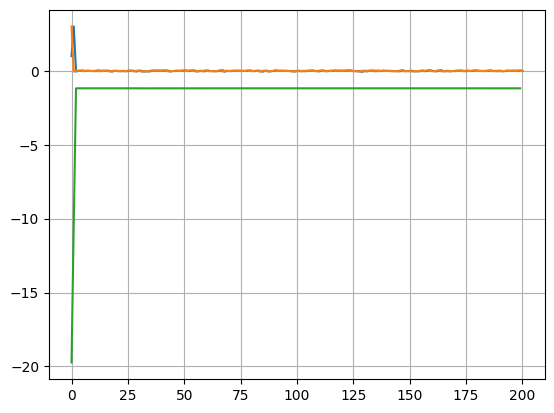

In [ ]:
import matplotlib.pyplot as plt
plt.plot(xs) # state
plt.plot(vs) # value
plt.grid()
